# Data Mining Detecting Faulty Water Pipes

In [151]:
#import the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE, SMOTENC
import folium
import xgboost as xgb
import pickle
import warnings

warnings.filterwarnings(action='ignore')

In [41]:
#load the data # load data
train_values = pd.read_csv('data/train_values.csv')
train_label = pd.read_csv('data/train_labels.csv')
df = train_values.merge(train_label, on='id')

## EDA and Preprocessing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [4]:
df.shape

(59400, 41)

In [5]:
df.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... water_quality  \
0  34.938093  -9.856322                  none            0  ...          soft   
1  34.698766  -2.147466              Zahanati            0  ...          soft   
2  37.460664  -3.821329           Kwa Mahundi            0  ...          soft   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  ...          soft   
4  31.130847  -1.825359               Shuleni            0  ...          soft   

  quality_group      quantity  quantity_group                source  \
0          good        enough          enough                spring   
1          good  insufficient    insufficient  rainwater harvesting   
2          good        enough          enough                   dam   
3          good           dry             dry           machine dbh   
4          good      seasonal        seasonal  rainwater harvesting   

            source_type source_class              waterpoint_type  \
0                spring  groundwater           communal standpipe   
1  rainwater harvesting      surface           communal standpipe   
2                   dam      surface  communal standpipe multiple   
3              borehole  groundwater  communal standpipe multiple   
4  rainwater harvesting      surface           communal standpipe   

  waterpoint_type_group    status_group  
0    communal standpipe      functional  
1    communal standpipe      functional  
2    communal standpipe      functional  
3    communal standpipe  non functional  
4    communal standpipe      functional  

[5 rows x 41 columns]

In [6]:
df.describe()

id     amount_tsh    gps_height     longitude      latitude  \
count  59400.000000   59400.000000  59400.000000  59400.000000  5.940000e+04   
mean   37115.131768     317.650385    668.297239     34.077427 -5.706033e+00   
std    21453.128371    2997.574558    693.116350      6.567432  2.946019e+00   
min        0.000000       0.000000    -90.000000      0.000000 -1.164944e+01   
25%    18519.750000       0.000000      0.000000     33.090347 -8.540621e+00   
50%    37061.500000       0.000000    369.000000     34.908743 -5.021597e+00   
75%    55656.500000      20.000000   1319.250000     37.178387 -3.326156e+00   
max    74247.000000  350000.000000   2770.000000     40.345193 -2.000000e-08   

        num_private   region_code  district_code    population  \
count  59400.000000  59400.000000   59400.000000  59400.000000   
mean       0.474141     15.297003       5.629747    179.909983   
std       12.236230     17.587406       9.633649    471.482176   
min        0.000000      1.000000       0.000000      0.000000   
25%        0.000000      5.000000       2.000000      0.000000   
50%        0.000000     12.000000       3.000000     25.000000   
75%        0.000000     17.000000       5.000000    215.000000   
max     1776.000000     99.000000      80.000000  30500.000000   

       construction_year  
count       59400.000000  
mean         1300.652475  
std           951.620547  
min             0.000000  
25%             0.000000  
50%          1986.000000  
75%          2004.000000  
max          2013.000000

In [7]:
#check for missing values
df.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

There are a few colunms with missing values that needs to be investigated and addressed

In [8]:
#check for duplicate records
df[df['id'].duplicated()]

Empty DataFrame
Columns: [id, amount_tsh, date_recorded, funder, gps_height, installer, longitude, latitude, wpt_name, num_private, basin, subvillage, region, region_code, district_code, lga, ward, population, public_meeting, recorded_by, scheme_management, scheme_name, permit, construction_year, extraction_type, extraction_type_group, extraction_type_class, management, management_group, payment, payment_type, water_quality, quality_group, quantity, quantity_group, source, source_type, source_class, waterpoint_type, waterpoint_type_group, status_group]
Index: []

[0 rows x 41 columns]

In [10]:
#check ofr unique values
cat = df.select_dtypes(include=['object'])
cat.nunique()

date_recorded              356
funder                    1897
installer                 2145
wpt_name                 37400
basin                        9
subvillage               19287
region                      21
lga                        125
ward                      2092
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
status_group                 3
dtype: int64

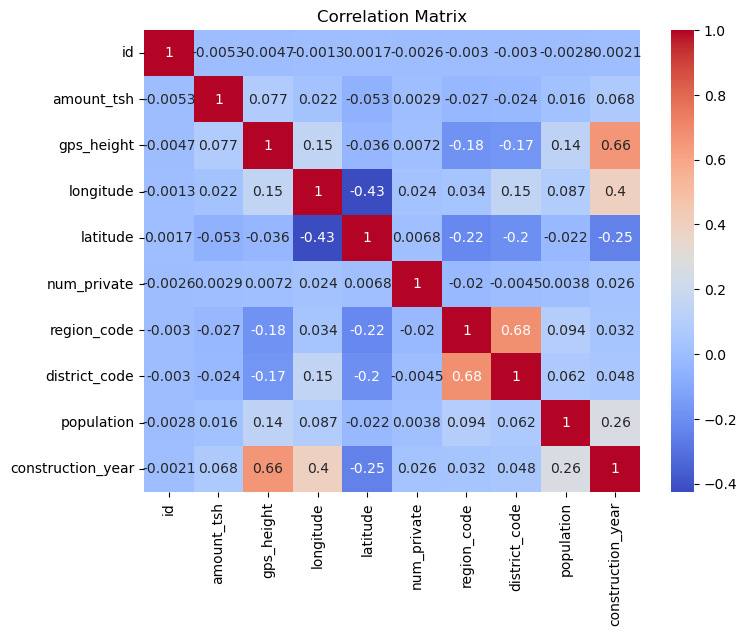

In [12]:
correlation_matrix = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [13]:
same_value_columns = []
    
    
for column in df.columns:
    unique_values = df[column].unique()
    if len(unique_values) > 1:
        continue
    same_value_columns.append(column)
    
print(same_value_columns)


['recorded_by']


There are a few highly correlated columns and the column recorded_by has the same value, so we need to further investigate and reove the unwanted columns

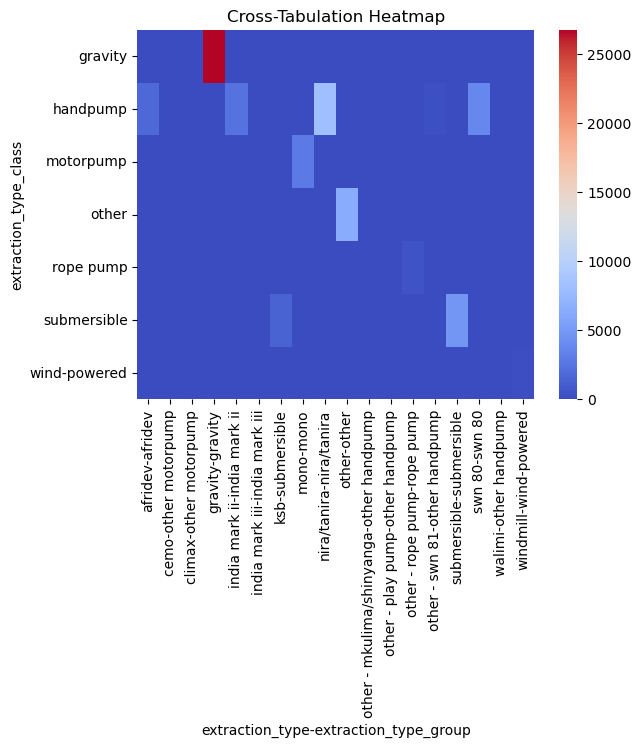

In [28]:
corr_columns = ['extraction_type_class', 'extraction_type', 'extraction_type_group']
cross_tab = pd.crosstab(index=df[corr_columns[0]], columns=[df[column] for column in corr_columns[1:]])
sns.heatmap(cross_tab, cmap='coolwarm')
plt.title('Cross-Tabulation Heatmap')
plt.show()

extraction_type_class has more or less all the values of the extraction_type and extraction_type_group, so we can remove those columns

In [42]:
corr_check = ['management','management_group','payment','payment_type','water_quality','quality_group','quantity','quantity_group','source','source_type','waterpoint_type','waterpoint_type_group','region','region_code']
df[corr_check]

management management_group                payment payment_type  \
0              vwc       user-group           pay annually     annually   
1              wug       user-group              never pay    never pay   
2              vwc       user-group         pay per bucket   per bucket   
3              vwc       user-group              never pay    never pay   
4            other            other              never pay    never pay   
...            ...              ...                    ...          ...   
59395  water board       user-group         pay per bucket   per bucket   
59396          vwc       user-group           pay annually     annually   
59397          vwc       user-group            pay monthly      monthly   
59398          vwc       user-group              never pay    never pay   
59399          vwc       user-group  pay when scheme fails   on failure   

      water_quality quality_group      quantity quantity_group  \
0              soft          good        enough         enough   
1              soft          good  insufficient   insufficient   
2              soft          good        enough         enough   
3              soft          good           dry            dry   
4              soft          good      seasonal       seasonal   
...             ...           ...           ...            ...   
59395          soft          good        enough         enough   
59396          soft          good        enough         enough   
59397      fluoride      fluoride        enough         enough   
59398          soft          good  insufficient   insufficient   
59399         salty         salty        enough         enough   

                     source           source_type  \
0                    spring                spring   
1      rainwater harvesting  rainwater harvesting   
2                       dam                   dam   
3               machine dbh              borehole   
4      rainwater harvesting  rainwater harvesting   
...                     ...                   ...   
59395                spring                spring   
59396                 river            river/lake   
59397           machine dbh              borehole   
59398          shallow well          shallow well   
59399          shallow well          shallow well   

                   waterpoint_type waterpoint_type_group       region  \
0               communal standpipe    communal standpipe       Iringa   
1               communal standpipe    communal standpipe         Mara   
2      communal standpipe multiple    communal standpipe      Manyara   
3      communal standpipe multiple    communal standpipe       Mtwara   
4               communal standpipe    communal standpipe       Kagera   
...                            ...                   ...          ...   
59395           communal standpipe    communal standpipe  Kilimanjaro   
59396           communal standpipe    communal standpipe       Iringa   
59397                    hand pump             hand pump        Mbeya   
59398                    hand pump             hand pump       Dodoma   
59399                    hand pump             hand pump     Morogoro   

       region_code  
0               11  
1               20  
2               21  
3               90  
4               18  
...            ...  
59395            3  
59396           11  
59397           12  
59398            1  
59399            5  

[59400 rows x 14 columns]

In [43]:
df.loc[df['management_group']=='user-group']['management'].value_counts()

vwc            40507
wug             6515
water board     2933
wua             2535
Name: management, dtype: int64

All these columns have repititive information and can be dropped

## Preprocessing

Dropping the columns that were determined to be dropped in EDA

In [44]:
drop_columns = ['extraction_type', 'extraction_type_group', 'payment', 'scheme_name', 'quality_group',
                   'quantity_group', 'source', 'waterpoint_type_group', 'recorded_by', 'num_private', 
                   'id', 'subvillage', 'wpt_name', 'ward', 'funder', 'date_recorded', 'public_meeting', 
                   'region_code', 'district_code', 'lga', 'scheme_management', 'source_class','management_group']
df = df.drop(drop_columns, axis=1)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55102 entries, 0 to 59399
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             55102 non-null  float64
 1   gps_height             55102 non-null  int64  
 2   installer              55102 non-null  object 
 3   longitude              55102 non-null  float64
 4   latitude               55102 non-null  float64
 5   basin                  55102 non-null  object 
 6   region                 55102 non-null  object 
 7   population             55102 non-null  int64  
 8   permit                 55102 non-null  object 
 9   construction_year      55102 non-null  int64  
 10  extraction_type_class  55102 non-null  object 
 11  management             55102 non-null  object 
 12  management_group       55102 non-null  object 
 13  payment_type           55102 non-null  object 
 14  water_quality          55102 non-null  object 
 15  qu

In [45]:
df = df.dropna()

In [46]:
df.isna().sum()

amount_tsh               0
gps_height               0
installer                0
longitude                0
latitude                 0
basin                    0
region                   0
population               0
permit                   0
construction_year        0
extraction_type_class    0
management               0
payment_type             0
water_quality            0
quantity                 0
source_type              0
waterpoint_type          0
status_group             0
dtype: int64

In [47]:
#convert the boolean to int for training
df['permit'] = df['permit'].astype(int)

In [48]:
zero_columns = df.columns[df.eq(0).sum() > 0]
zero_count = df[zero_columns].eq(0).sum()
zero_count_df = pd.DataFrame({'Column': zero_columns, 'Zero Count': zero_count})
print(zero_count_df)

                              Column  Zero Count
amount_tsh                amount_tsh       37811
gps_height                gps_height       18310
longitude                  longitude        1793
population                population       19250
permit                        permit       16907
construction_year  construction_year       18392


These huge number of 0 need to be investigated and fixed

In [49]:
df.loc[df['construction_year']!=0].describe()

amount_tsh    gps_height     longitude      latitude    population  \
count   36710.000000  36710.000000  36710.000000  36710.000000  36710.000000   
mean      471.881843    982.395015     36.015003     -6.358975    268.881694   
std      3074.841656    623.784917      2.609370      2.762486    542.812926   
min         0.000000    -63.000000     29.607122    -11.649440      0.000000   
25%         0.000000    351.000000     34.671850     -8.855908     30.000000   
50%         0.000000   1116.500000     36.691907     -6.351197    150.000000   
75%       200.000000   1471.000000     37.896261     -3.731978    304.000000   
max    250000.000000   2770.000000     40.345193     -1.042375  30500.000000   

             permit  construction_year  
count  36710.000000       36710.000000  
mean       0.717379        1996.888096  
std        0.450280          12.452883  
min        0.000000        1960.000000  
25%        0.000000        1987.000000  
50%        1.000000        2000.000000  
75%        1.000000        2008.000000  
max        1.000000        2013.000000

In [50]:
#replace with mean value
df['construction_year'].replace(to_replace = 0, value = 1996, inplace=True)

In [52]:
chk_col = ['latitude','longitude','gps_height']
fil_df = df[df['longitude'] == 0][chk_col]
print(fil_df)

           latitude  longitude  gps_height
21    -2.000000e-08        0.0           0
53    -2.000000e-08        0.0           0
168   -2.000000e-08        0.0           0
177   -2.000000e-08        0.0           0
253   -2.000000e-08        0.0           0
...             ...        ...         ...
59189 -2.000000e-08        0.0           0
59208 -2.000000e-08        0.0           0
59295 -2.000000e-08        0.0           0
59324 -2.000000e-08        0.0           0
59374 -2.000000e-08        0.0           0

[1793 rows x 3 columns]


since the gps_height is also 0 and only latitudes its better to drop these 0s

In [53]:
df = df.loc[df['longitude'] != 0]

In [55]:
df

amount_tsh  gps_height     installer  longitude   latitude  \
0          6000.0        1390         Roman  34.938093  -9.856322   
1             0.0        1399       GRUMETI  34.698766  -2.147466   
2            25.0         686  World vision  37.460664  -3.821329   
3             0.0         263        UNICEF  38.486161 -11.155298   
4             0.0           0       Artisan  31.130847  -1.825359   
...           ...         ...           ...        ...        ...   
59394       500.0         351      ML appro  37.634053  -6.124830   
59395        10.0        1210           CES  37.169807  -3.253847   
59396      4700.0        1212          Cefa  35.249991  -9.070629   
59398         0.0           0          Musa  35.861315  -6.378573   
59399         0.0         191         World  38.104048  -6.747464   

                         basin       region  population  permit  \
0                   Lake Nyasa       Iringa         109       0   
1                Lake Victoria         Mara         280       1   
2                      Pangani      Manyara         250       1   
3      Ruvuma / Southern Coast       Mtwara          58       1   
4                Lake Victoria       Kagera           0       1   
...                        ...          ...         ...     ...   
59394              Wami / Ruvu     Morogoro          89       1   
59395                  Pangani  Kilimanjaro         125       1   
59396                   Rufiji       Iringa          56       1   
59398                   Rufiji       Dodoma           0       1   
59399              Wami / Ruvu     Morogoro         150       1   

       construction_year extraction_type_class   management payment_type  \
0                   1999               gravity          vwc     annually   
1                   2010               gravity          wug    never pay   
2                   2009               gravity          vwc   per bucket   
3                   1986           submersible          vwc    never pay   
4                   1996               gravity        other    never pay   
...                  ...                   ...          ...          ...   
59394               2007           submersible          vwc      monthly   
59395               1999               gravity  water board   per bucket   
59396               1996               gravity          vwc     annually   
59398               1996              handpump          vwc    never pay   
59399               2002              handpump          vwc   on failure   

      water_quality      quantity           source_type  \
0              soft        enough                spring   
1              soft  insufficient  rainwater harvesting   
2              soft        enough                   dam   
3              soft           dry              borehole   
4              soft      seasonal  rainwater harvesting   
...             ...           ...                   ...   
59394          soft        enough              borehole   
59395          soft        enough                spring   
59396          soft        enough            river/lake   
59398          soft  insufficient          shallow well   
59399         salty        enough          shallow well   

                   waterpoint_type    status_group  
0               communal standpipe      functional  
1               communal standpipe      functional  
2      communal standpipe multiple      functional  
3      communal standpipe multiple  non functional  
4               communal standpipe      functional  
...                            ...             ...  
59394           communal standpipe  non functional  
59395           communal standpipe      functional  
59396           communal standpipe      functional  
59398                    hand pump      functional  
59399                    hand pump      functional  

[53309 rows x 18 columns]

Since installer is categorical and has huge number of different values, we need to reduce the dimensions by correcting spelling issues and other manual data entry issues.

In [57]:
sorted(df['installer'].unique())

['-',
 '0',
 'A.D.B',
 'AAR',
 'ABASIA',
 'ABD',
 'ABDALA',
 'ABDUL',
 'AC',
 'ACORD',
 'ACRA',
 'ACTION AID',
 'ACTIVE TANK CO',
 'ACTIVE TANK CO LTD',
 'AD',
 'ADAP',
 'ADB',
 'ADP',
 'ADP Busangi',
 'ADRA',
 'ADRA /Government',
 'ADRA/Government',
 'AF',
 'AFRICA',
 'AFRICA MUSLIM',
 'AFRICAN DEVELOPMENT FOUNDATION',
 'AFRICAN REFLECTIONS FOUNDATION',
 'AGRICAN',
 'AI',
 'AIC',
 'AIC KI',
 'AICT',
 'AIXOS',
 'ALIA',
 'ALLYS',
 'AMP Contract',
 'AMP Contracts',
 'AMP contractor',
 'AMREF',
 'ANGLI',
 'ANGLIKANA CHURCH',
 'ANGRIKANA',
 'ANSWAR',
 'AQAL',
 'AQUA BLUES ANGELS',
 'AQUA WEL',
 'AQUA Wat',
 'AQUA Wel',
 'AQUARMAN DRILLERS',
 'ASDP',
 'ATIGH BUILDINGS',
 'AUSTRALIA',
 'AUWASA',
 'Aartisa',
 'Abdallah Ally Wazir',
 'Accra',
 'Action Aid',
 'Action Contre La Faim',
 'Action Contre la Faim',
 'Active KMK',
 'Active MKM',
 'Adam',
 'Adam Kea',
 'Adam mualuaka',
 'Adra',
 'Adra /Community',
 'Adra/ Community',
 'Adra/Community',
 'Adrs',
 'Af',
 'Africa',
 'Africa Amini Alama',


There are several misspelt words in installer

In [66]:
mapping = {
    ('Central government', 'Tanzania Government', 'Cental Government', 'Tanzania government',
     'Cebtral Government', 'Centra Government', 'central government', 'CENTRAL GOVERNMENT',
     'TANZANIA GOVERNMENT', 'Central govt', 'Centr', 'Centra govt', 'Tanzanian Government',
     'Tanzania'): 'Central Government',
    ('District COUNCIL', 'DISTRICT COUNCIL', 'Counc', 'District council', 'District Counci',
     'Council', 'COUN', 'Distri', 'District  Council'): 'District Council',
    ('villigers', 'villager', 'villagers', 'Villa', 'Village', 'Villi', 'Village Council',
     'Village Counil', 'Villages', 'Vill', 'Village community', 'Villaers',
     'Village Community', 'Villag', 'Villege Council', 'Village council', 'Village Council',
     'Villagerd', 'Villager', 'Village Technician', 'Village Office', 'VILLAGE COUNCIL',
     'Village community members', 'VILLAG', 'Village Government', 'Village govt', 'VILLAGERS',
     'Village  Council'): 'Villagers',
    ('District Water Department', 'District water depar', 'Distric Water Department'): 'District water department',
    ('FinW', 'Fini water', 'FINI WATER', 'FIN WATER', 'Finwater', 'FINN WATER', 'FinW', 'FW',
     'FinWater', 'FiNI WATER'): 'Fini Water',
    ('RC CHURCH', 'RC Churc', 'RC', 'RC Ch', 'RC C', 'RC CH', 'RC church', 'RC CATHORIC', 'Ch'): 'RC Church',
    ('world vision', 'World Division', 'World vision', 'WORLD VISION', 'World Vission'): 'World Vision',
    ('Unisef', 'Unicef'): 'UNICEF',
    'DANID': 'DANIDA',
    ('Commu', 'Communit', 'commu', 'COMMU', 'COMMUNITY', 'Adra /Community', 'Communit',
     'Adra/Community', 'Adra/ Community'): 'Community',
    ('GOVERNMENT', 'GOVER', 'GOVERNME', 'GOVERM', 'GOVERN', 'Gover', 'Gove', 'Governme', 'Governmen'): 'Government',
    ('Hesawa', 'hesawa'): 'HESAWA',
    ('JAICA', 'JICA', 'Jica', 'Jeica', 'JAICA CO'): 'Jaica',
    ('KKKT _ Konde and DWE', 'KKT', 'KKKT Church', 'KkKT'): 'KKKT',
    '0': 'Unknown'
}

for keys in mapping:
    df['installer'] = df['installer'].replace(to_replace=keys, value=mapping[keys])


In [69]:
installer_20 = df.installer.value_counts(normalize=True).head(20).index.tolist()  


df['installer'] = [type_ if type_ in installer_20
                      else "OTHER" for type_ in df['installer']]

In [70]:
df['installer'].value_counts()

OTHER                 19283
DWE                   16214
Government             2468
Community              1791
DANIDA                 1601
HESAWA                 1180
RWE                    1178
District Council       1173
Central Government     1115
KKKT                   1102
Fini Water              952
Unknown                 780
TCRS                    702
World Vision            660
CES                     610
RC Church               484
Villagers               482
LGA                     408
WEDECO                  397
TASAF                   371
Jaica                   358
Name: installer, dtype: int64

In [71]:
df['status_group'].value_counts()

functional                 29026
non functional             20829
functional needs repair     3454
Name: status_group, dtype: int64

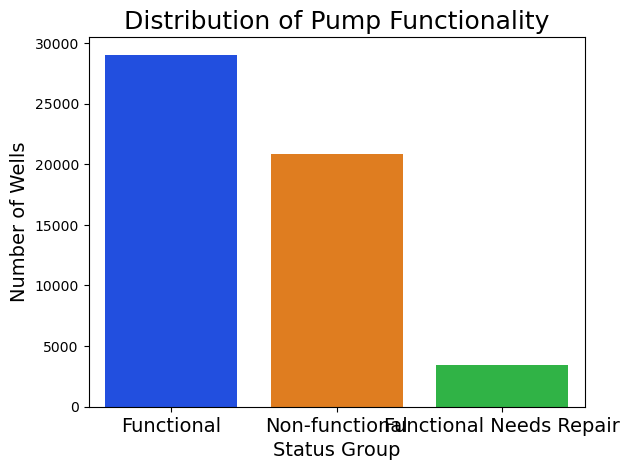

In [72]:
sns.countplot(x='status_group', palette='bright', data=df)

plt.title('Distribution of Pump Functionality', fontsize=18)
plt.ylabel('Number of Wells', fontsize=14)
plt.xlabel('Status Group', fontsize=14)
plt.xticks(ticks=[0, 1, 2], labels=['Functional', 'Non-functional', 'Functional Needs Repair'], rotation=0, size=14)
plt.show()

Now we need ot explore the correlation between the target groups to each of the important feature

Text(0, 0.5, 'Number of Wells')

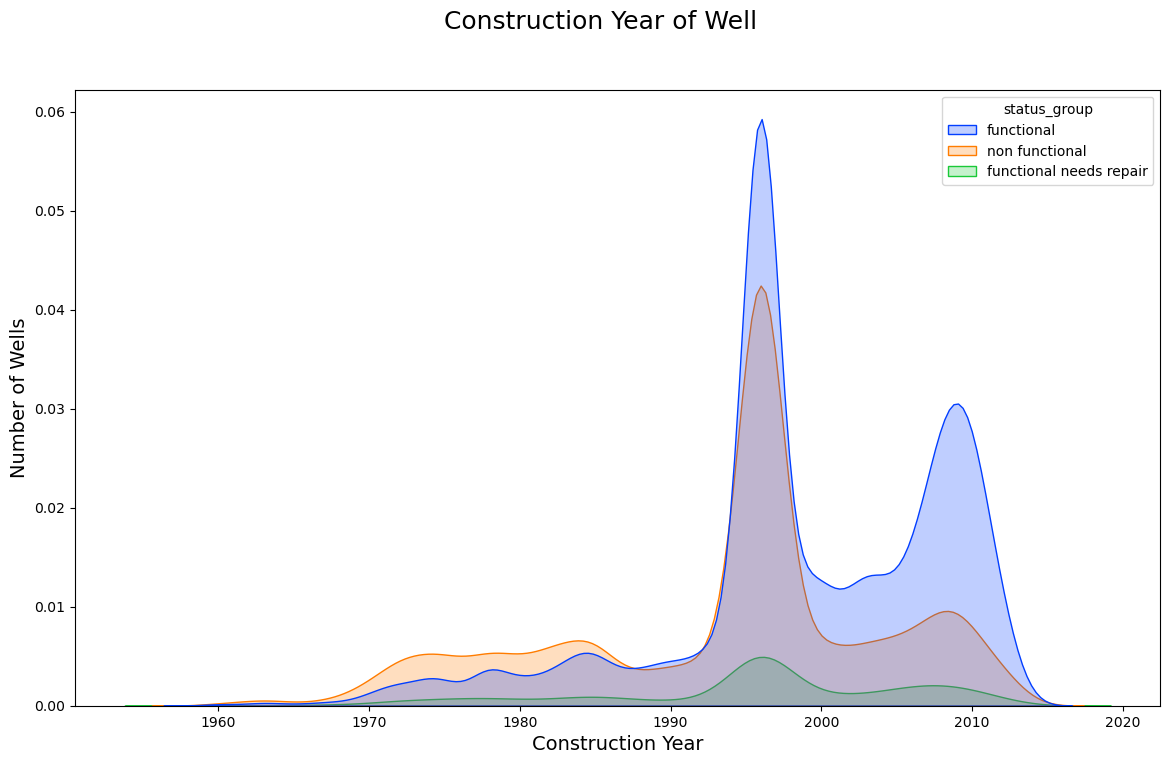

In [73]:
fig, ax = plt.subplots(figsize=(14,8))
ax = sns.kdeplot(data=df, x='construction_year', hue='status_group', palette='bright', fill=True)

fig.suptitle('Construction Year of Well', fontsize=18)
plt.xlabel("Construction Year", fontsize=14)
plt.ylabel("Number of Wells", fontsize=14)

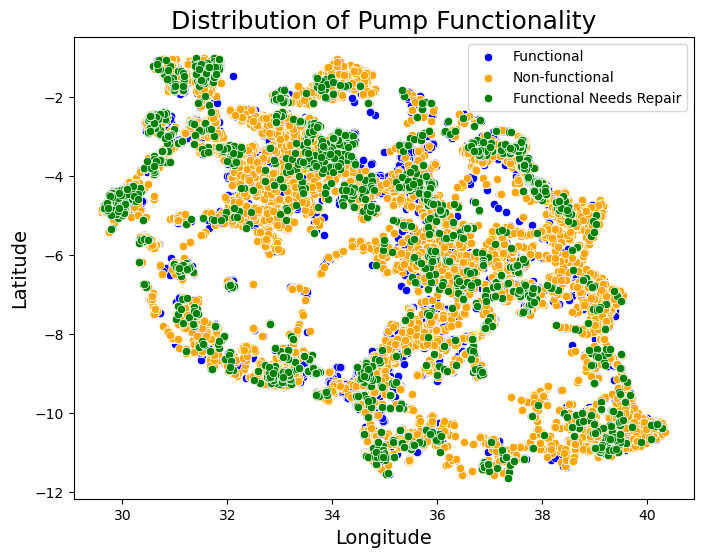

In [75]:
df_f = df[df['status_group'] == 'functional']
df_nf = df[df['status_group'] == 'non functional']
df_fnr = df[df['status_group'] == 'functional needs repair']


plt.figure(figsize=(8, 6))
sns.scatterplot(x='longitude', y='latitude', data=df_f, color='blue', label='Functional')
sns.scatterplot(x='longitude', y='latitude', data=df_nf, color='orange', label='Non-functional')
sns.scatterplot(x='longitude', y='latitude', data=df_fnr, color='green', label='Functional Needs Repair')


plt.title('Distribution of Pump Functionality', fontsize=18)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.legend()
plt.show()

In [78]:
this_map = folium.Map()
for coord in lat_long_nf[::5]:
    folium.CircleMarker(location=coord, opacity=0.6, color='orange', radius=1).add_to(this_map)
for coord in lat_long_f[::5]:
    folium.CircleMarker(location=coord, opacity=0.6, color='blue', radius=1).add_to(this_map)
for coord in lat_long_fnr[::5]:
    folium.CircleMarker(location=coord, opacity=0.6, color='green', radius=1).add_to(this_map) 
this_map.fit_bounds(this_map.get_bounds())

In [79]:
this_map

In [80]:
#change the target to integer
df['status'] = df.status_group.map({"non functional":0, "functional needs repair":1, "functional":2})
df = df.drop('status_group', axis=1)
df.head()

amount_tsh  gps_height     installer  longitude   latitude  \
0      6000.0        1390         OTHER  34.938093  -9.856322   
1         0.0        1399         OTHER  34.698766  -2.147466   
2        25.0         686  World Vision  37.460664  -3.821329   
3         0.0         263         OTHER  38.486161 -11.155298   
4         0.0           0         OTHER  31.130847  -1.825359   

                     basin   region  population  permit  construction_year  \
0               Lake Nyasa   Iringa         109       0               1999   
1            Lake Victoria     Mara         280       1               2010   
2                  Pangani  Manyara         250       1               2009   
3  Ruvuma / Southern Coast   Mtwara          58       1               1986   
4            Lake Victoria   Kagera           0       1               1996   

  extraction_type_class management payment_type water_quality      quantity  \
0               gravity        vwc     annually          soft        enough   
1               gravity        wug    never pay          soft  insufficient   
2               gravity        vwc   per bucket          soft        enough   
3           submersible        vwc    never pay          soft           dry   
4               gravity      other    never pay          soft      seasonal   

            source_type              waterpoint_type  status  
0                spring           communal standpipe       2  
1  rainwater harvesting           communal standpipe       2  
2                   dam  communal standpipe multiple       2  
3              borehole  communal standpipe multiple       0  
4  rainwater harvesting           communal standpipe       2

## Modelling

In [81]:
c_col = ['installer','basin','region','extraction_type_class','management','payment_type','water_quality',
           'quantity','source_type','waterpoint_type']
i_col = ['amount_tsh','gps_height','longitude','latitude','population','permit','construction_year']

In [83]:
df_main = pd.get_dummies(df,columns=c_col,drop_first=True)
df_main.shape

(53309, 102)

In [86]:
y = df_main['status']
X = df_main.drop(['status'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

prelimnary modelling

In [140]:
lr = Pipeline([('ss', StandardScaler()), 
                    ('lr', LogisticRegression())])
lr.fit(X_train, y_train)
test_preds = lr.predict(X_test)

target_names= ['non func', 'func need repair', 'functional']
print(classification_report(y_test, test_preds, target_names=target_names))


                  precision    recall  f1-score   support

        non func       0.79      0.66      0.72      4157
func need repair       0.45      0.05      0.09       671
      functional       0.73      0.90      0.81      5834

        accuracy                           0.75     10662
       macro avg       0.66      0.54      0.54     10662
    weighted avg       0.74      0.75      0.73     10662



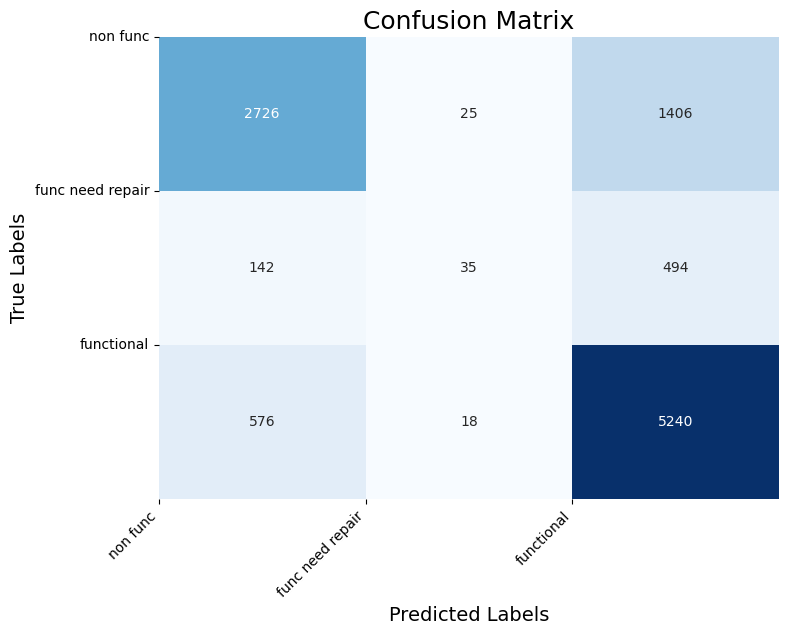

In [105]:
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(np.arange(len(target_names)), labels=target_names, rotation=45, ha='right')
plt.yticks(np.arange(len(target_names)), labels=target_names, rotation=0)
plt.show()

In [141]:
y_bin_test = label_binarize(y_test, classes=[0, 1, 2])
model_pred_proba = lr.predict_proba(X_test)
print(roc_auc_score(y_bin_test, model_pred_proba, multi_class='ovr'))

0.8315494474020954


In [142]:
knn = Pipeline([('ss', StandardScaler()), 
                    ('knn', KNeighborsClassifier(n_neighbors=9))])
knn.fit(X_train, y_train)
test_preds = knn.predict(X_test)
print(classification_report(y_test, test_preds, target_names=target_names))

                  precision    recall  f1-score   support

        non func       0.77      0.73      0.75      4157
func need repair       0.43      0.21      0.28       671
      functional       0.77      0.85      0.81      5834

        accuracy                           0.76     10662
       macro avg       0.66      0.60      0.61     10662
    weighted avg       0.75      0.76      0.75     10662



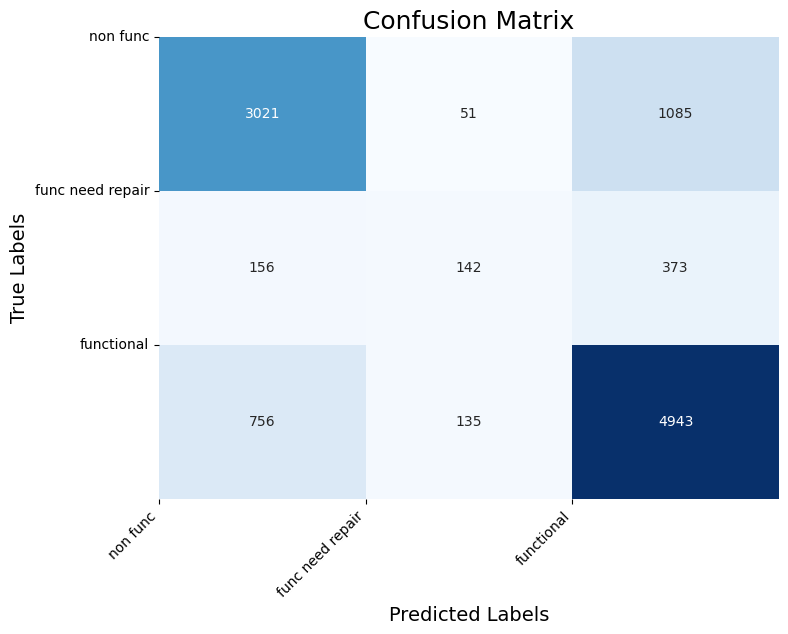

In [110]:
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(np.arange(len(target_names)), labels=target_names, rotation=45, ha='right')
plt.yticks(np.arange(len(target_names)), labels=target_names, rotation=0)
plt.show()

In [143]:
model_pred_proba = knn.predict_proba(X_test)
print(roc_auc_score(y_bin_test, model_pred_proba, multi_class='ovr'))

0.8503339133267368


In [144]:
dt = Pipeline([('ss', StandardScaler()), 
            ('dt', DecisionTreeClassifier(criterion='gini', max_depth=20, min_samples_split=2))])

dt.fit(X_train, y_train)
test_preds = dt.predict(X_test)
print(classification_report(y_test, test_preds, target_names=target_names))


                  precision    recall  f1-score   support

        non func       0.80      0.74      0.77      4157
func need repair       0.38      0.32      0.34       671
      functional       0.79      0.84      0.82      5834

        accuracy                           0.77     10662
       macro avg       0.65      0.63      0.64     10662
    weighted avg       0.77      0.77      0.77     10662



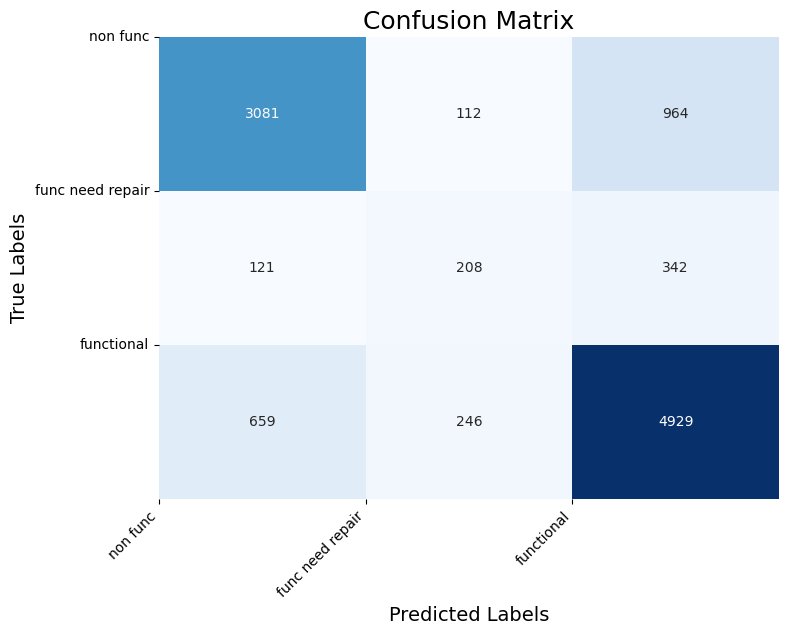

In [114]:
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(np.arange(len(target_names)), labels=target_names, rotation=45, ha='right')
plt.yticks(np.arange(len(target_names)), labels=target_names, rotation=0)
plt.show()

In [145]:
model_pred_proba = dt.predict_proba(X_test)
print(roc_auc_score(y_bin_test, model_pred_proba, multi_class='ovr'))

0.7680808194737622


In [146]:
xgb = Pipeline([('ss', StandardScaler()), ('xgb', XGBClassifier(n_estimators=250))])

xgb.fit(X_train, y_train)
test_preds = xgb.predict(X_test)
print(classification_report(y_test, test_preds, target_names=target_names))

                  precision    recall  f1-score   support

        non func       0.85      0.77      0.81      4157
func need repair       0.57      0.25      0.34       671
      functional       0.80      0.91      0.85      5834

        accuracy                           0.81     10662
       macro avg       0.74      0.64      0.67     10662
    weighted avg       0.80      0.81      0.80     10662



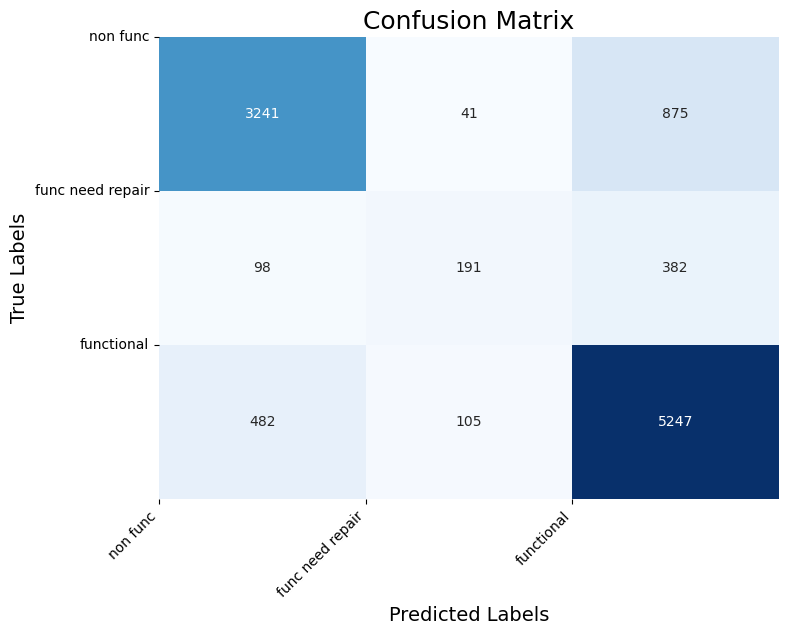

In [127]:
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(np.arange(len(target_names)), labels=target_names, rotation=45, ha='right')
plt.yticks(np.arange(len(target_names)), labels=target_names, rotation=0)
plt.show()

In [147]:
model_pred_proba = xgb.predict_proba(X_test)
print(roc_auc_score(y_bin_test, model_pred_proba, multi_class='ovr'))

0.8970518917660989


## Hyperparameter tuning

Xgboost model gives the best performance, lets tune the performance further using randomsearchcv

In [125]:
xgb = XGBClassifier()
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [4, 6, 8, 10],
    'subsample': [0.5, 0.7],
    'n_estimators': [100, 250, 500],
}

rs_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, cv=5)
rs_xgb.fit(X_train, y_train)

print(f'Best parameters are {rs_xgb.best_params_}')
print(f'Best score: {rs_xgb.best_score_}')
print(f'Best estimator score: {rs_xgb.best_estimator_.score(X_test, y_test)}')


Best parameters are {'subsample': 0.5, 'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.1}
Best score: 0.8078880591793778
Best estimator score: 0.8157006190208216


In [117]:
xgb = Pipeline([('ss', StandardScaler()), 
                     ('xgb', XGBClassifier(learning_rate=0.1, max_depth=10, min_child_weight=2,
                      n_estimators=250, subsample=0.7))])

xgb.fit(X_train, y_train)
test_preds = xgb.predict(X_test)
print(classification_report(y_test, test_preds, target_names=target_names))

                  precision    recall  f1-score   support

        non func       0.85      0.78      0.81      4157
func need repair       0.57      0.28      0.38       671
      functional       0.81      0.91      0.85      5834

        accuracy                           0.82     10662
       macro avg       0.74      0.65      0.68     10662
    weighted avg       0.81      0.82      0.81     10662



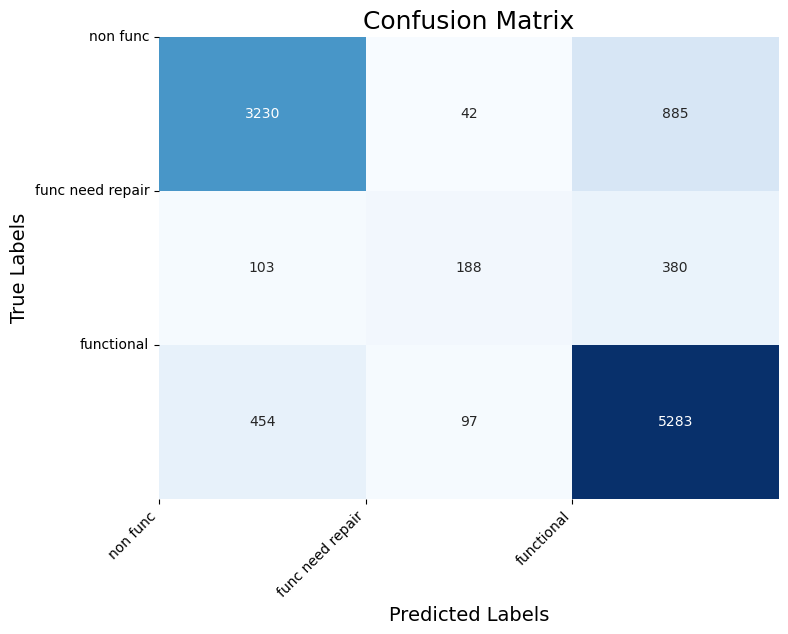

In [118]:
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(np.arange(len(target_names)), labels=target_names, rotation=45, ha='right')
plt.yticks(np.arange(len(target_names)), labels=target_names, rotation=0)
plt.show()

In [148]:
model_pred_proba = xgb.predict_proba(X_test)
print(roc_auc_score(y_bin_test, model_pred_proba, multi_class='ovr'))

0.8970518917660989


## Data rebalancing

In [131]:
oversample = SMOTE(sampling_strategy = 'auto', n_jobs = -1)
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [132]:
xgb_smote = Pipeline([('ss', StandardScaler()), 
                      ('xgb smote', XGBClassifier(learning_rate=0.1, max_depth=10, min_child_weight=2,
                        n_estimators=250, subsample=0.7))])
xgb_smote.fit(X_train_smote, y_train_smote)
test_preds = xgb_smote.predict(X_test)
print(classification_report(y_test, test_preds, target_names=target_names))

                  precision    recall  f1-score   support

        non func       0.84      0.78      0.81      4157
func need repair       0.36      0.39      0.38       671
      functional       0.82      0.86      0.84      5834

        accuracy                           0.80     10662
       macro avg       0.67      0.68      0.67     10662
    weighted avg       0.80      0.80      0.80     10662



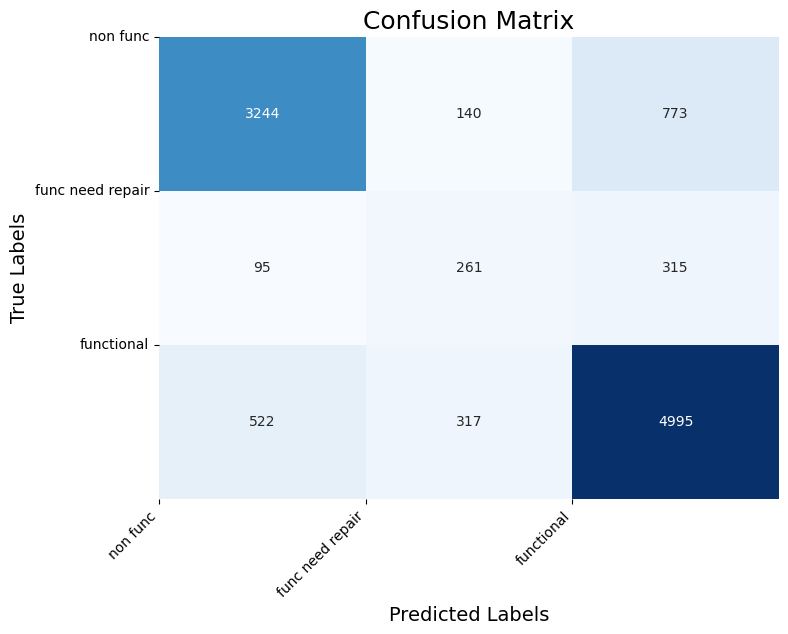

In [133]:
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(np.arange(len(target_names)), labels=target_names, rotation=45, ha='right')
plt.yticks(np.arange(len(target_names)), labels=target_names, rotation=0)
plt.show()

In [149]:
model_pred_proba = xgb_smote.predict_proba(X_test)
print(roc_auc_score(y_bin_test, model_pred_proba, multi_class='ovr'))

0.8932640591972819


Text(0, 0.5, 'True Positive rate')

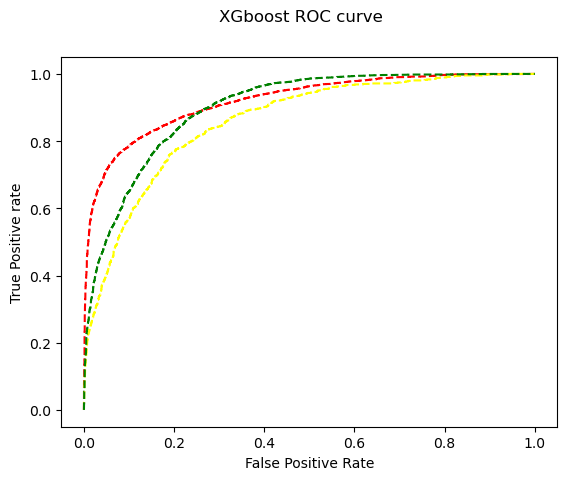

In [153]:
fig, ax = plt.subplots()
n_class = 3

fpr = {}
tpr = {}
thresh ={}
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, model_pred_proba[:,i], pos_label=i)
plt.plot(fpr[0], tpr[0], linestyle='--',color='red', label='Non Functional')
plt.plot(fpr[1], tpr[1], linestyle='--',color='yellow', label='Functional Needs Repair')
plt.plot(fpr[2], tpr[2], linestyle='--',color='green', label='Functional')
plt.suptitle('XGboost ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

## Conclusion

In conclusion, the XG Boost model outperformed other models in predicting faulty water pipes in Tanzania. It achieved an impressive ROC AUC of 89% and an accuracy of 81%. These results demonstrate the model's strong ability to differentiate between faulty and non-faulty water pipes. The high ROC AUC indicates its effectiveness in identifying potential problem areas, while the accuracy reflects its overall correctness in classifying pipe statuses. The XG Boost model can be a valuable tool for proactive maintenance and resource allocation, ensuring a reliable water supply for the population.